In [1]:
# loading all the dependencies
import pandas as pd
import numpy as np
pd.options.display.float_format ='{:,.1f}'.format
import matplotlib.pyplot as plt
from IPython.display import Image


%matplotlib inline  
from scipy.stats import gmean
from scipy import integrate
from openpyxl import load_workbook
import matplotlib.pylab as pylab

import uncertainties as uc
from uncertainties import ufloat
from uncertainties import unumpy


%run Utility_Functions.ipynb

## Methods and Statistics
Ranges and values with ± are given as 1 standard error of the values 

# Cardiomyocytes
Cardiomyocytes are the heart muscle. They are massive cells. Some of them are multinucleated but with only few nucleus, unlike the thousands in Skeletal muscles myocytes.   

Our estimate for their turnover is mainly based on a resourceful source: [Bergmann et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26073943) which developed a model for the turnover of the cells in the heart, based on C14 measurments. On the way, they have got an estimate for the number of cells and their mass too. 

## Cardiomyocytes number
[Bergmann et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26073943) used antibodies to marker the cardiomyocytes obtained from 29 postmortem hearts samples, and then estimate their density of. Combined with volume measurements they estimated the number of cells, concluding that there is no significant change with age, as can be seen in figure 1.D taken from the source    

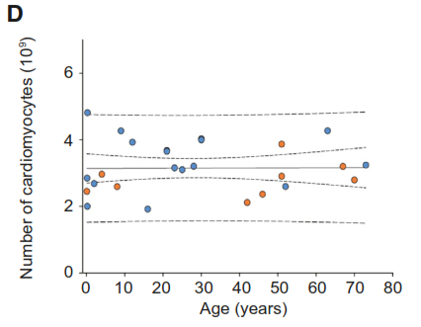

In [2]:
Image('Cardiomyocytes_number.png', width=400) #loading image from Bergmann et al., 2015

In [3]:
#initiating a CellTypeResDF object to save results and print them:
cardio = CellTypesResDF(['cardiomyocytes'])
                         
#uploading concentrated data regarding the properties of cardiomyocytes 
card_prop = pd.read_excel('Cardiomyocytes.xlsx','Properties',index_col=0,usecols = range(6))

#using the number and SEM given in the source
cardio.res['number'] = ufloat( card_prop.loc['number of cardimyocytes','value'],
                                                 card_prop.loc['number of cardimyocytes','SEM'])
                         
cardio.print_params('number')

Number of cardiomyocytes is: (3.2±0.1)×10⁹ cells


## Cardiomyocytes mass
[Bergmann et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26073943) determined cardiomyocyte volume by deﬁning local vertical windows at which myocytes have been cut along their longitudinal axis, labeling their cell borders and nuclei and the use of three-dimensional nucleator
with ﬁve test lines.

The volume of the cardiomyocytes is dependent on the age of the patient as can be seen in figure S1.F taken from the source:

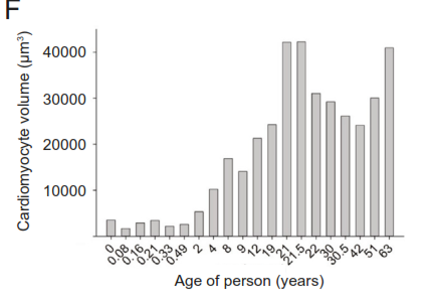

In [4]:
Image('Cardiomyocytes_volume.png', width=400, height=250) #loading image from Bergmann et al., 2015

For the reference volume we use the measurements for patient in the range of ages similar to this of the reference man: 19.5-30.5 years old. 
Combined with the mass density ([Vinnakota and Bassingthwaighte, 2003](https://www.ncbi.nlm.nih.gov/pubmed/14693681)) of the cells we get an estimate for their mean mass:

In [6]:
#uploading volume data from Bergmann 
card_vol_data = pd.read_excel('Cardiomyocytes.xlsx','Volume',usecols = range(2))
#computing the mean volume and its sem
card_vol = ufloat(card_vol_data['volume (µm^3)'].mean(),card_vol_data['volume (µm^3)'].std()/np.sqrt(card_vol_data['volume (µm^3)'].size))
#using the density data from Vinnakota and Bassingthwaighte, 2003 (the SD serves as the error)
card_density = ufloat(card_prop.loc['myocardial mass density','value'],card_prop.loc['myocardial mass density','SD'])

#using a designated ufloat parameter to propogate the errors 
cardio.res['cell mass'] = card_vol*card_density
cardio.res['total cellular mass'] = cardio.res['number']*cardio.res['cell mass']/10**12
#converting the results from pg to g

#printing using a uniform format
cardio.print_params(['cell mass','total cellular mass'])


Cell mass of cardiomyocytes is: 35000±3000 pg
Total cellular mass of cardiomyocytes is: 111±12 grams


The total cellular mass of the cardiomyocytes could be compare to the predicted total cellualr mass of the heart, based on a furmola from [Wang et al., 2004](https://www.ncbi.nlm.nih.gov/pubmed/14532167). We try to estimate the average mass of the other cells in the heart to check whether the estimate for the cellular mass of cardiomyocytes is reasonable

In [7]:
non_cm_cells = ufloat(card_prop.loc['number of endothelial cells','value'],
                      card_prop.loc['number of endothelial cells','SEM']) +ufloat(card_prop.loc['number of mesenchymal cells','value'],card_prop.loc['number of mesenchymal cells','SEM']) 

heart_pot = ufloat(card_prop.loc['whole heart potassium','value'],card_prop.loc['whole heart potassium','SD'])
conv_f = ufloat(card_prop.loc['cell mass/potassium conc.','value'],card_prop.loc['cell mass/potassium conc.','SD'])

#following Wang et al., 2004 formula and converting from kg to g twice
heart_cellular_mass = 10**6*heart_pot*conv_f/card_prop.loc['potassium molar mass','value']

#estiamting the total mass of all other cell by the difference between the total cellular mass and the cardiomyocytes total mass:
non_cm_cells_total_mass = heart_cellular_mass-cardio.res.loc['cardiomyocytes','total cellular mass']
#dividing by their total number to get their mean mass:
mean_non_cm_cell_mass = 10**12*non_cm_cells_total_mass/non_cm_cells

print('Total mass of the heart: {:0.0f} grams'.format(card_prop.loc['total mass of heat','value']))
print('Total cellular mass in the heart: {:0.0fP} grams'.format(round_vec(heart_cellular_mass)))
cardio.print_params('total cellular mass')
print('Cellular mass of other cells:{:0.0fP} grams'.format(round_vec(non_cm_cells_total_mass)))
print('Estimate of other cells number:{:0.1eP} cells'.format(non_cm_cells))
print('Mean mass of other cells: {:0.0fP} pg'.format(round_vec(mean_non_cm_cell_mass)))


Total mass of the heart: 330 grams
Total cellular mass in the heart: 170±60 grams
Total cellular mass of cardiomyocytes is: 111±12 grams
Cellular mass of other cells:60±60 grams
Estimate of other cells number:(1.4±0.1)×10¹⁰ cells
Mean mass of other cells: 4000±5000 pg


Although the uncertainty is great, the size of the other cells seems to be in the right order of magnitude

## Cardiomyocytes turnover
[Bergmann et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26073943) developed a model for the turnover of the cells in the heart, based on C14 measurments. They fitted numerous model to their measurment and got the best fit for a model that assume the death rates of cardiomyocytes goes down with the age of the person in the form:
$$ \gamma(a) =\frac{\gamma_{0}\gamma_{1}}{a+\gamma_{1}}$$
Where $a$ is the age of the person, $\gamma(a)$ is the death rate at age $a$,  and $\gamma_{0}, \gamma_{1}$ are parameters describing the decreasing death rate.

[Bergmann et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26073943) found two good fits, each for either the right or the left ventricles.
Here, we use both fits to get an estimate for the death rate at age 25 years, and use the average death rate as the basis for the cellular turnover.



<ErrorbarContainer object of 3 artists>

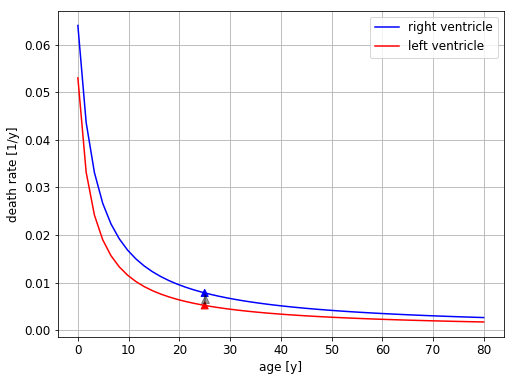

In [8]:
gamma_data = pd.read_excel('Cardiomyocytes.xlsx','Death_rate',index_col=0,usecols = range(4))

#defining the model as described 
gamma_a = lambda g0,g1,a: (g0*g1)/(a+g1)

#computing the results for the parameters of the two sides, to be plotted
ages = np.linspace(0, 80)

gammas_right =gamma_a(gamma_data.loc['right','gamma0'],gamma_data.loc['right','gamma1'],ages)  #using the prediction made using the function  
gammas_left = gamma_a(gamma_data.loc['left','gamma0'],gamma_data.loc['left','gamma1'],ages)

#defining the parameters of the graph illustration
params = {'legend.fontsize': 'large',
          'figure.figsize': (8,6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


#plotting the results for the two models
plt.plot(ages,gammas_right,'b',label = 'right ventricle')
plt.plot(ages,gammas_left,'r',label = 'left ventricle')
plt.xlabel('age [y]')
plt.ylabel('death rate [1/y]')
plt.grid()
plt.legend()

#computing the mean death rate at a reference age  
AGE = 25
col_name = 'at '+ str(AGE) + 'y'
gamma_data[col_name] =0
for side in gamma_data.index:
    gamma_data.loc[side,col_name] = gamma_a(gamma_data.loc[side,'gamma0'],gamma_data.loc[side,'gamma1'],AGE)

ref_death_rate = ufloat(gamma_data[col_name].mean(),gamma_data[col_name].std()/np.sqrt(gamma_data[col_name].size))

#plotting the results of the models for each of the venticles at the reference age and their mean
plt.scatter(AGE*np.ones(gamma_data[col_name].size),gamma_data[col_name],marker='^',s=50,c=['r','b'])
plt.errorbar(AGE,ref_death_rate.nominal_value ,yerr =ref_death_rate.std_dev,ls = '',marker='^',c='k', alpha=0.4,label = 'mean',ms=8)



Deriving the mean lifespan given as $\frac{1}{\gamma}$, and the cellular and mass turnover :

In [9]:
#using the death rate data to derive the lifespan and turnover of the cells:
cardio.res['lifespan'] = 365/ref_death_rate  #converting from 1/years to days
cardio.res['cellular turnover rate'] = cardio.res['number']/cardio.res['lifespan'] 
cardio.res['cellular mass turnover rate'] = cardio.res['total cellular mass']/cardio.res['lifespan'] 
#using method for printing in years units
cardio.print_in_years(['lifespan','cellular turnover rate','cellular mass turnover rate'])
print('_'*30)
cardio.print_params(['lifespan','cellular turnover rate','cellular mass turnover rate'])


Lifespan of cardiomyocytes is: 150±30 years
Cellular turnover rate of cardiomyocytes is: (2±0)×10⁷ cells per year
Cellular mass turnover rate of cardiomyocytes is: 0.7±0.2 grams per year
______________________________
Lifespan of cardiomyocytes is: 56000±11000 days
Cellular turnover rate of cardiomyocytes is: 57000±12000 cells per day
Cellular mass turnover rate of cardiomyocytes is: 0.0020±0.0005 grams per day


## Saving the results to excel

In [10]:
cardio.export_to_excel('Summary.xlsx')